In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# GPyTorch Regression Tutorial

### 目標
以下の関係の回帰をガウス過程により求める。

$$
\begin{align}
    y &= \sin (2\pi x) + \epsilon \\
    \epsilon &\sim \mathcal{N}(0, 0.04)
\end{align}
$$

上式を丁寧に書くと

$$
\begin{align}
    y &= f(x) + \epsilon \\
    f(x) &= \sin (2\pi x) \\
     \epsilon &\sim \mathcal{N}(0, {\sigma}^2) \\
    \sigma &= 0.2
\end{align}
$$

である。これは、観測値$y$は、説明変数$x$によって$f(x)$の分布から生成される値を、分散の観測誤差${\sigma}^2$のもとで観測したものといえる。

#### 理解のために、とくに以下のページ・書籍が参考になる
- https://recruit.cct-inc.co.jp/tecblog/deep-learning/gpytorch-01/
- 『ガウス過程と機械学習』3.4.2 等。以下、「書籍」と略す


In [4]:

# 上の条件に基づいてデータを生成すると
# Set up training data

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## ガウス過程
${\boldsymbol f}$がガウス過程により生成されているとすると、書籍3.2.3のガウス過程の定義より、

$$
{\boldsymbol f} \sim \mathcal{N}({\boldsymbol \mu}, {\boldsymbol K})  \equiv \mathcal{N}({\boldsymbol f} \mid  {\boldsymbol \mu}, {\boldsymbol K}) 
$$

と表される。説明変数 ${\boldsymbol X} = ({\boldsymbol x}_1, {\boldsymbol x}_2), ..., {\boldsymbol x}_N$ が与えられたあとの観測値 ${\boldsymbol y}$ の確率分布(尤度)を計算する。${\boldsymbol y}$ は ${\boldsymbol f}= (f({\boldsymbol x}_1), f({\boldsymbol x}_2), ..., f({\boldsymbol x}_N))$ を通してのみ ${\boldsymbol X}$ に依存するため、${\boldsymbol f}$ に関して期待値をとると、

$$
\begin{align}
  p({\boldsymbol y} \mid {\boldsymbol X}) &= \int p({\boldsymbol y}, {\boldsymbol f} \mid {\boldsymbol X})d{\boldsymbol f} \\
  &= \int p({\boldsymbol y} \mid {\boldsymbol f}) p({\boldsymbol f} \mid {\boldsymbol X})d{\boldsymbol f} \\
  &= \int \mathcal{N}({\boldsymbol y} \mid {\boldsymbol f}, {\sigma}^2 {\boldsymbol I}) \mathcal{N}({\boldsymbol f} \mid {\boldsymbol \mu}, {\boldsymbol K})d{\boldsymbol f} \\
  &= \mathcal{N}({\boldsymbol \mu}, {\boldsymbol K} + {\sigma}^2 {\boldsymbol I})
\end{align}
$$

となる。したがって、$y$はカーネル関数を新しく
$$
k'({\boldsymbol x}_n,{\boldsymbol x}_{n'}) = k({\boldsymbol x}_n,{\boldsymbol x}_{n'}) + {\sigma}^2 \delta (n,n')
$$
とおいたガウス過程に従う。



## GpyTorch との関係
GpyTorch の **ExactGP** クラスの **likelihood** を入力するのは、${\sigma}$を同時に学習するためである。
例えば、カーネルをガウスカーネルとすると、上記のようにガウス誤差を含んだ場合のガウスカーネルは、

$$
k(x, x') = \theta_1 \exp\left(-\frac{(x-x)^2}{\theta_2}\right) + \theta_3\delta(x,x')
$$

であるので(ただし$\theta_3=\sigma^2$)、**ExactGP** を用いた学習では、${\boldsymbol \theta}=(\theta_1, \theta_2, \theta_3)$を最適化していることになる。

In [5]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [7]:
model.named_parameters()


<generator object Module.named_parameters at 0x7fbc84d1c678>

In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.947   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.916   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.883   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.846   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.805   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.759   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.710   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.660   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.612   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.569   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.530   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.495   lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.462   lengthscale: 0.272   noise: 0.260
Iter 14/50 - Loss: 0.431   lengthscale: 0.255   noise: 0.237
Iter 15/50 - Loss: 0.401   lengthscale: 0.242   noise: 0.216
Iter 16/50 - Loss: 0.372   lengthscale: 0.232   noise: 0.197
Iter 17/50 - Loss: 0.343   length

In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## GpyTorch の Model の出力について
今回定義した **ExactGPModel** から得られる出力を見ると、

1. 　model(test_x) による出力
2. 　1. の出力に likelihood をかける

の2ステップになっている。1. の出力は、$ \mathcal{N}({\boldsymbol \mu}, {\boldsymbol K}) $
の分布による出力に対応し、これにガウス分布で定義される誤差関数の分を掛けることで、観測値の確率分布 $ \mathcal{N}({\boldsymbol \mu}, {\boldsymbol K} + {\sigma}^2 {\boldsymbol I}) $ からの出力を得ていることになる。


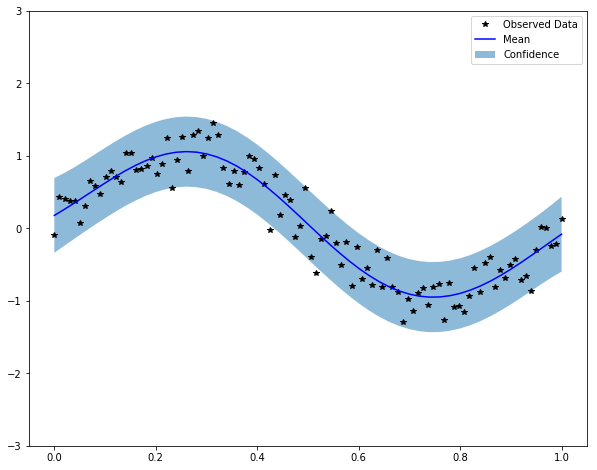

In [12]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
#     lower, upper = f_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [22]:
observed_pred.mean

tensor([ 0.0654,  0.1846,  0.3013,  0.4138,  0.5200,  0.6185,  0.7075,  0.7859,
         0.8526,  0.9067,  0.9477,  0.9750,  0.9886,  0.9885,  0.9749,  0.9481,
         0.9085,  0.8568,  0.7937,  0.7199,  0.6363,  0.5439,  0.4437,  0.3370,
         0.2251,  0.1093, -0.0088, -0.1275, -0.2452, -0.3600, -0.4701, -0.5735,
        -0.6685, -0.7533, -0.8263, -0.8860, -0.9312, -0.9610, -0.9747, -0.9720,
        -0.9529, -0.9179, -0.8679, -0.8038, -0.7271, -0.6396, -0.5431, -0.4398,
        -0.3317, -0.2213, -0.1106])

In [30]:
f_pred = model(test_x)
f_pred.mean

tensor([ 0.0654,  0.1846,  0.3013,  0.4138,  0.5200,  0.6185,  0.7075,  0.7859,
         0.8526,  0.9067,  0.9477,  0.9750,  0.9886,  0.9885,  0.9749,  0.9481,
         0.9085,  0.8568,  0.7937,  0.7199,  0.6363,  0.5439,  0.4437,  0.3370,
         0.2251,  0.1093, -0.0088, -0.1275, -0.2452, -0.3600, -0.4701, -0.5735,
        -0.6685, -0.7533, -0.8263, -0.8860, -0.9312, -0.9610, -0.9747, -0.9720,
        -0.9529, -0.9179, -0.8679, -0.8038, -0.7271, -0.6396, -0.5431, -0.4398,
        -0.3317, -0.2213, -0.1106], grad_fn=<ViewBackward>)

In [28]:
f_pred.confidence_region()

(tensor([-0.1088,  0.0447,  0.1859,  0.3133,  0.4268,  0.5277,  0.6171,  0.6956,
          0.7626,  0.8177,  0.8599,  0.8886,  0.9034,  0.9042,  0.8910,  0.8644,
          0.8248,  0.7731,  0.7099,  0.6362,  0.5527,  0.4605,  0.3606,  0.2541,
          0.1423,  0.0266, -0.0916, -0.2104, -0.3283, -0.4433, -0.5536, -0.6572,
         -0.7523, -0.8371, -0.9100, -0.9698, -1.0152, -1.0454, -1.0599, -1.0583,
         -1.0406, -1.0070, -0.9578, -0.8942, -0.8175, -0.7304, -0.6364, -0.5403,
         -0.4471, -0.3611, -0.2848], grad_fn=<SubBackward0>),
 tensor([ 0.2397,  0.3244,  0.4167,  0.5143,  0.6133,  0.7093,  0.7980,  0.8763,
          0.9426,  0.9958,  1.0354,  1.0614,  1.0739,  1.0729,  1.0588,  1.0318,
          0.9923,  0.9406,  0.8775,  0.8036,  0.7198,  0.6272,  0.5268,  0.4199,
          0.3078,  0.1920,  0.0740, -0.0446, -0.1621, -0.2767, -0.3865, -0.4898,
         -0.5848, -0.6696, -0.7426, -0.8023, -0.8473, -0.8766, -0.8895, -0.8856,
         -0.8652, -0.8289, -0.7779, -0.7134, -0

In [29]:
observed_pred.confidence_region()

(tensor([-0.3577, -0.2256, -0.1011,  0.0153,  0.1233,  0.2223,  0.3115,  0.3899,
          0.4567,  0.5110,  0.5522,  0.5799,  0.5938,  0.5938,  0.5803,  0.5535,
          0.5140,  0.4623,  0.3991,  0.3253,  0.2417,  0.1494,  0.0493, -0.0574,
         -0.1693, -0.2851, -0.4031, -0.5219, -0.6396, -0.7545, -0.8646, -0.9681,
         -1.0631, -1.1479, -1.2209, -1.2806, -1.3259, -1.3557, -1.3696, -1.3671,
         -1.3483, -1.3137, -1.2638, -1.1998, -1.1232, -1.0357, -0.9398, -0.8382,
         -0.7342, -0.6314, -0.5337]),
 tensor([ 0.4886,  0.5947,  0.7038,  0.8122,  0.9168,  1.0146,  1.1036,  1.1820,
          1.2486,  1.3024,  1.3431,  1.3702,  1.3835,  1.3833,  1.3695,  1.3427,
          1.3031,  1.2514,  1.1883,  1.1144,  1.0308,  0.9383,  0.8381,  0.7314,
          0.6194,  0.5036,  0.3856,  0.2669,  0.1492,  0.0345, -0.0755, -0.1790,
         -0.2740, -0.3588, -0.4318, -0.4915, -0.5366, -0.5663, -0.5798, -0.5768,
         -0.5575, -0.5222, -0.4719, -0.4077, -0.3311, -0.2435, -0.1464,

In [39]:
f_pred
f_pred.covariance_matrix

tensor([[ 7.5943e-03,  5.9472e-03,  4.4536e-03,  ..., -4.2173e-05,
         -8.0265e-05, -1.1488e-04],
        [ 5.9470e-03,  4.8884e-03,  3.8932e-03,  ..., -1.4151e-05,
         -4.6416e-05, -8.0270e-05],
        [ 4.4534e-03,  3.8930e-03,  3.3288e-03,  ...,  8.7894e-06,
         -1.4149e-05, -4.2179e-05],
        ...,
        [-4.2174e-05, -1.4153e-05,  8.7882e-06,  ...,  3.3287e-03,
          3.8931e-03,  4.4535e-03],
        [-8.0266e-05, -4.6416e-05, -1.4152e-05,  ...,  3.8931e-03,
          4.8879e-03,  5.9472e-03],
        [-1.1487e-04, -8.0265e-05, -4.2172e-05,  ...,  4.4537e-03,
          5.9472e-03,  7.5944e-03]], grad_fn=<AddmmBackward>)

In [38]:
observed_pred

MultivariateNormal(loc: torch.Size([51]), covariance_matrix: torch.Size([51, 51]), precision_matrix: torch.Size([51, 51]), scale_tril: torch.Size([51, 51]))

In [43]:
likelihood

('noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
